# Day 2: Basic Preprocessing EEG

In [3]:
import mne
import matplotlib.pyplot as plt

### 1. Download contoh dataset EEG gratis dari PhysioNet

In [4]:
sample_file = mne.datasets.eegbci.load_data(subject=1, runs=[1])[0]

/var/folders/zk/5mfnhbj13qzgxy_2dx8gcv8w0000gn/T/ipykernel_27244/3301596606.py:1: FutureWarning: The ``subject`` parameter is deprecated and will be removed in version 1.9. Use the ``subjects`` parameter (note the `s`) to suppress this warning.
  sample_file = mne.datasets.eegbci.load_data(subject=1, runs=[1])[0]


### 2. Load data EEG 

In [5]:
raw = mne.io.read_raw_edf(sample_file, preload=True)
print(raw.info)

Extracting EDF parameters from /Users/syifani/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


### 3. Ambil info channel & sampling rate

In [6]:
ch_names = raw.info["ch_names"]
fs = raw.info["sfreq"]

print(f"\nJumlah channel: {len(ch_names)}")
print(f"Nama channel: {ch_names}")
print(f"Sampling rate: {fs} Hz")


Jumlah channel: 64
Nama channel: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']
Sampling rate: 160.0 Hz


### 4. Plot 10 detik pertama semua channel

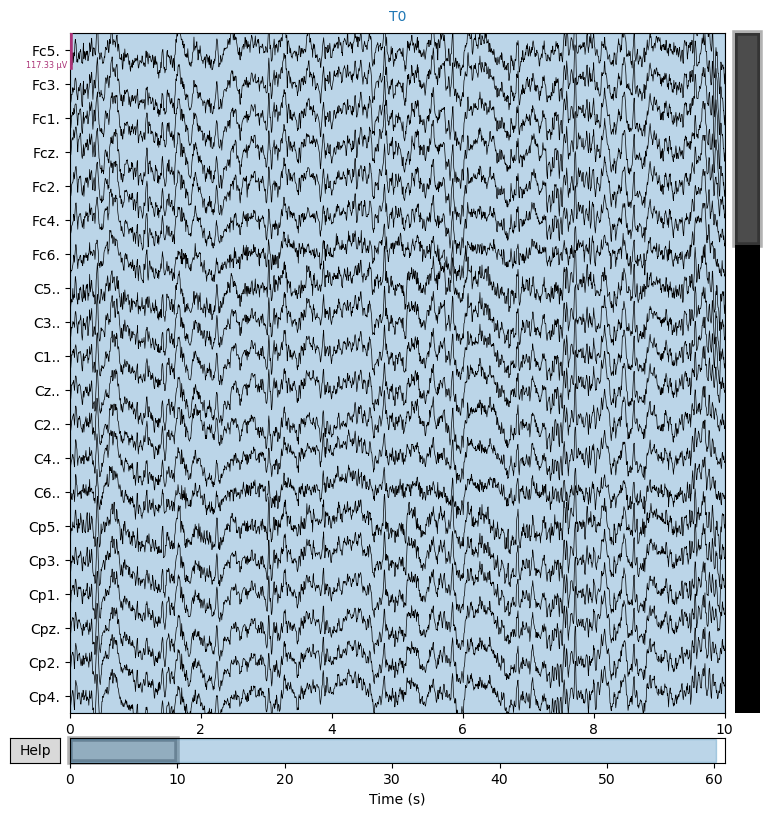

In [7]:
fig = raw.plot(duration=10, scalings='auto')
plt.show()

### 5. Simpan plot ke file PNG

In [8]:
fig.savefig("EEG_first10sec.png", dpi=300)

### 6. Plot channel tertentu (misal 'C3')

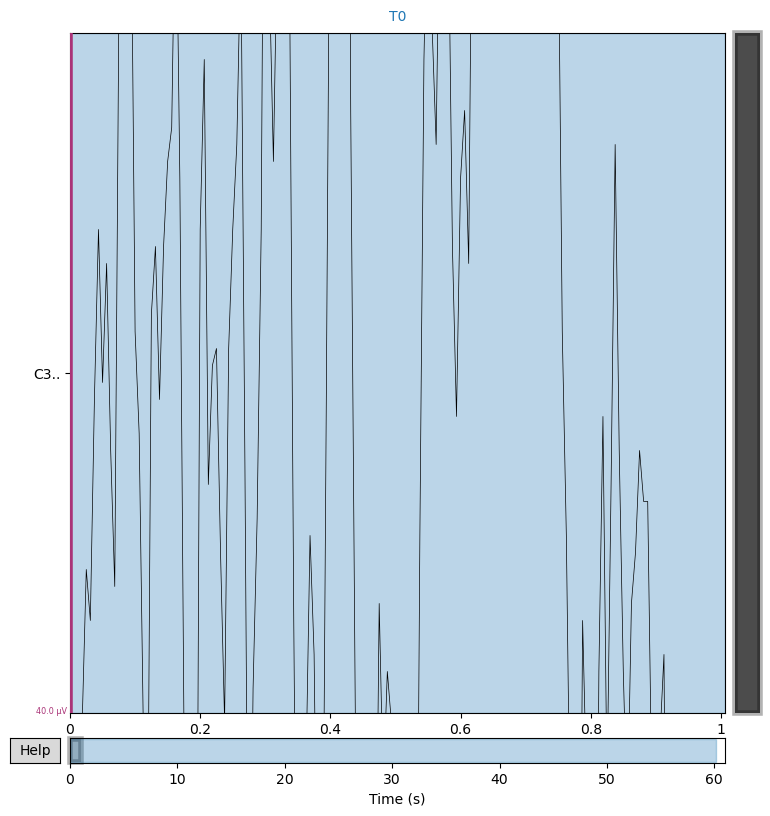

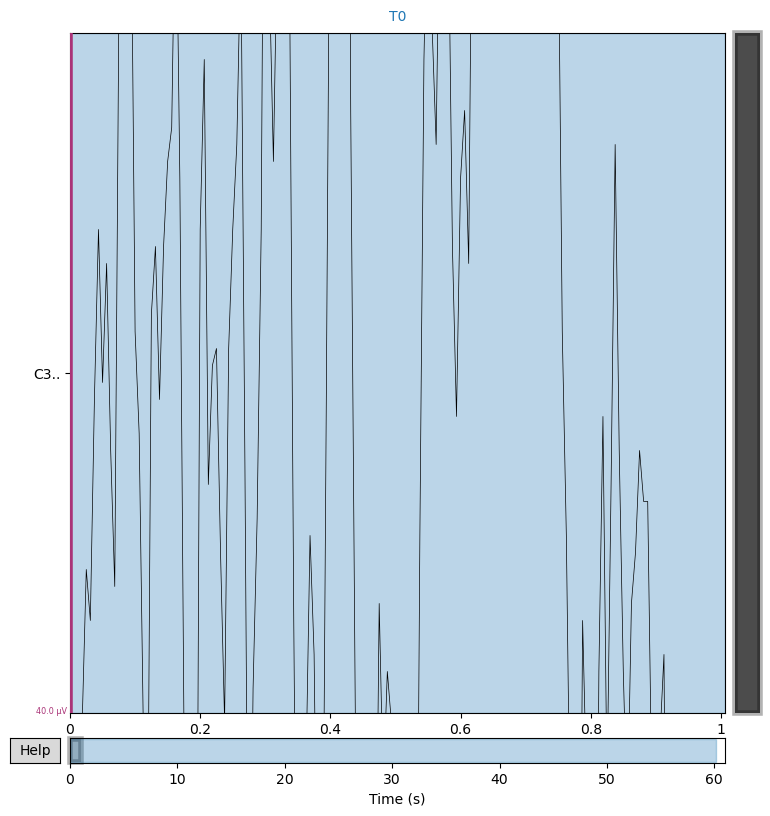

In [16]:
c3_name = [c for c in raw.ch_names if 'C3' in c][0]
raw.plot(duration=1, picks=[c3_name])
